In [8]:
import os
import glob
import random
import shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import boto3
import io

#### Prepare files

In [2]:
os.getcwd()

'C:\\Users\\zwdua\\OneDrive - Northeastern University\\桌面\\INFO7374 Digtal Marketing\\Visual Search'

In [6]:
# the data source folder
imagePath = 'C:\mlSpace\DeepFashion\images\images'
files = glob.glob(imagePath+'\*.jpg')

In [8]:
len(files)

44096

In [12]:
selected_files = random.sample(files, 5000)
# random.choices

In [22]:

# Set data destination paths
dst_path = 'C:\\Users\\zwdua\\OneDrive - Northeastern University\\桌面\\INFO7374 Digtal Marketing\\Visual Search\\images\\'

# Move file
for x in selected_files:
    shutil.copy(x, dst_path)

In [24]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


#### Prepare Model

In [ ]:
from transformers import CLIPProcessor, CLIPVisionModel
#model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPVisionModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [42]:
model.cuda()

CLIPVisionModel(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (position_embedding): Embedding(50, 768)
    )
    (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2

## CLIP Model
- [What is CLIP?](https://openai.com/research/clip)
- [Documentation](https://huggingface.co/transformers/v4.6.0/model_doc/clip.html)

#### Single Image

In [61]:
image = [Image.open(x) for x in selected_files[:2]]

image_input = processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    image_encoding = model(image_input['pixel_values'])
image_encoding

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.0125,  0.5159,  0.3908,  ..., -0.1412,  0.2412, -0.0401],
         [-0.1767,  0.1357, -0.3911,  ..., -0.1985,  0.1671,  0.2520],
         [-0.1180,  0.3977, -0.1633,  ...,  0.0166,  0.1267,  0.2499],
         ...,
         [ 0.4439, -0.2379,  0.1476,  ...,  0.3123,  0.2037,  0.1949],
         [ 0.3475,  0.8158, -0.0286,  ...,  0.3182,  0.7514,  0.1681],
         [-0.3171,  0.3919, -0.2557,  ..., -0.0998,  0.0894,  0.2094]],

        [[-0.1159,  0.5767,  0.1226,  ..., -0.2060,  0.1871, -0.0765],
         [-0.0461,  0.3420, -0.4243,  ..., -0.0339,  0.0364,  0.4671],
         [ 0.0039,  0.3289, -0.3255,  ..., -0.0277,  0.1028,  0.3448],
         ...,
         [-0.0072,  0.7689, -0.0622,  ..., -0.1653,  0.1955,  0.0037],
         [-0.5289,  0.4876, -0.3419,  ..., -0.1318, -0.1013,  0.2178],
         [-0.3976,  0.5551, -0.5300,  ..., -0.1486, -0.5523,  0.3464]]],
       device='cuda:0'), pooler_output=tensor([[ 0.1629,  1.7334,  1.72

In [62]:
image_encoding.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

#### Batch Image
Prepossessing 5000 images

In [65]:
# Set the batch size
batch_size = 32

# Process the images in batches
num_images = len(selected_files)
image_encodings = []
for i in range(0, num_images, batch_size):
    # Load and preprocess the images in the batch
    batch_files = selected_files[i:i+batch_size]
    batch_images = [Image.open(x) for x in batch_files]
    image_input = processor(images=batch_images, return_tensors="pt").to(device)

    # Encode the images in the batch
    with torch.no_grad():
        batch_encodings = model(image_input['pixel_values'])
    
    # Append the batch encodings to the list of all encodings
    image_encodings.append(batch_encodings['pooler_output'])

# Concatenate the encodings from all batches
image_encodings = torch.cat(image_encodings)

# Use the image encodings
print(image_encodings.shape)


torch.Size([5000, 768])


In [67]:
image_features = image_encodings.cpu().numpy()

In [72]:
np.save('image_features.npy', image_features)
# image_features = np.load('image_features.npy')


In [75]:
# Save the strings to a text file
with open('image_paths.txt', 'w') as f:
    for string in selected_files:
        f.write(string + '\n')


In [ ]:
# Load a list of strings from a text file
# with open('iamge_paths.txt', 'r') as f:
#     selected_files = [line.strip() for line in f.readlines()]

In [92]:
# Save the tensor to a file
torch.save(image_encodings, 'image_features.pt')
#image_encodings = torch.load('image_features.pt')


#### Search Image

In [13]:
#device = torch.device("mps")
device = 'cpu'

In [17]:
with open('image_all.txt', 'r') as f:
    files = [line.strip() for line in f.readlines()]
with open('image_paths.txt', 'r') as f:
    selected_files = [line.strip() for line in f.readlines()]
image_encodings = torch.load('image_features.pt', map_location=torch.device('cpu'))
test_image = files[1000]
#display(Image.open(test_image))

In [11]:
# initialize
from transformers import CLIPProcessor, CLIPVisionModel
#model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPVisionModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = 'cpu'

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.encoder.layers.4.layer_norm1.weight', 'text_model.encoder.layers.8.mlp.fc2.weight', 'text_model.encoder.layers.4.self_attn.v_proj.bias', 'text_model.encoder.layers.6.mlp.fc2.bias', 'text_model.encoder.layers.8.self_attn.q_proj.weight', 'text_model.encoder.layers.2.mlp.fc1.weight', 'text_model.encoder.layers.8.layer_norm1.weight', 'text_model.encoder.layers.6.self_attn.q_proj.bias', 'text_model.encoder.layers.11.layer_norm2.bias', 'text_model.encoder.layers.6.self_attn.q_proj.weight', 'text_model.encoder.layers.3.self_attn.out_proj.bias', 'text_model.encoder.layers.4.self_attn.v_proj.weight', 'text_model.encoder.layers.4.self_attn.out_proj.bias', 'text_model.encoder.layers.6.mlp.fc1.bias', 'text_model.encoder.layers.7.self_attn.q_proj.bias', 'text_model.encoder.layers.2.mlp.fc2.bias', 'text_model.encoder.layers.0.s

In [20]:
image = Image.open(test_image) 

image_input = processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    image_encoding = model(image_input['pixel_values'])


In [21]:
similarity = F.cosine_similarity(image_encoding['pooler_output'], image_encodings, dim=1)
similarity

tensor([0.6932, 0.6856, 0.8265,  ..., 0.6861, 0.6747, 0.7141])

In [22]:
# assume we want top 20 similar images, i.e. the search returns 20 images
topk_values, topk_indices = torch.topk(similarity, k=20)

In [23]:
image_out_index = topk_indices.cpu().numpy()
image_out_values = topk_values.cpu().numpy()


In [24]:
search_outputs = [selected_files[x] for x in image_out_index]

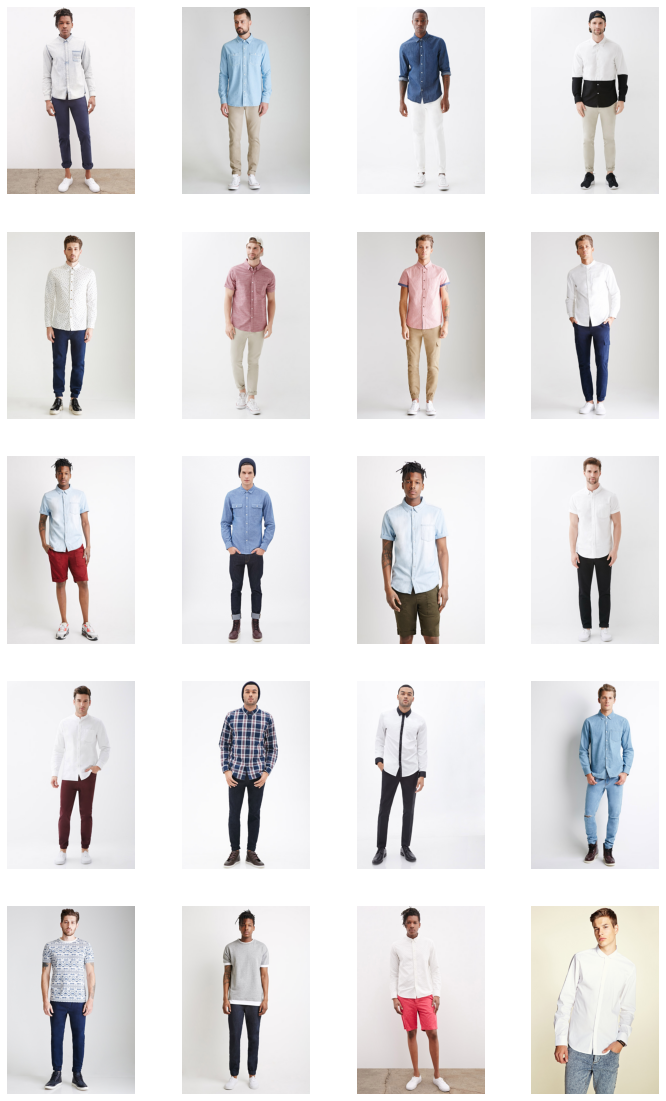

In [25]:
# Set up a 5x4 grid of subplots
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(12, 20))

# Loop through the image paths and display each image in a subplot
for i, ax in enumerate(axs.flat):
    # Load the image from file using Pillow
    img = Image.open(search_outputs[i])

    # Display the image in the subplot
    ax.imshow(img)
    ax.axis('off')

plt.show()


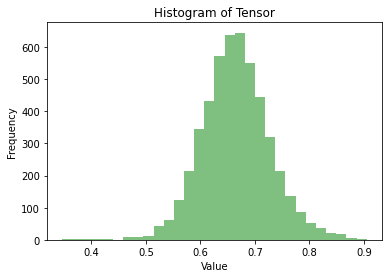

In [133]:
# Plot a histogram of the tensor
plt.hist(similarity.cpu().numpy(), bins=30, alpha=0.5, color='green')

# Set the title and labels
plt.title('Histogram of Tensor')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

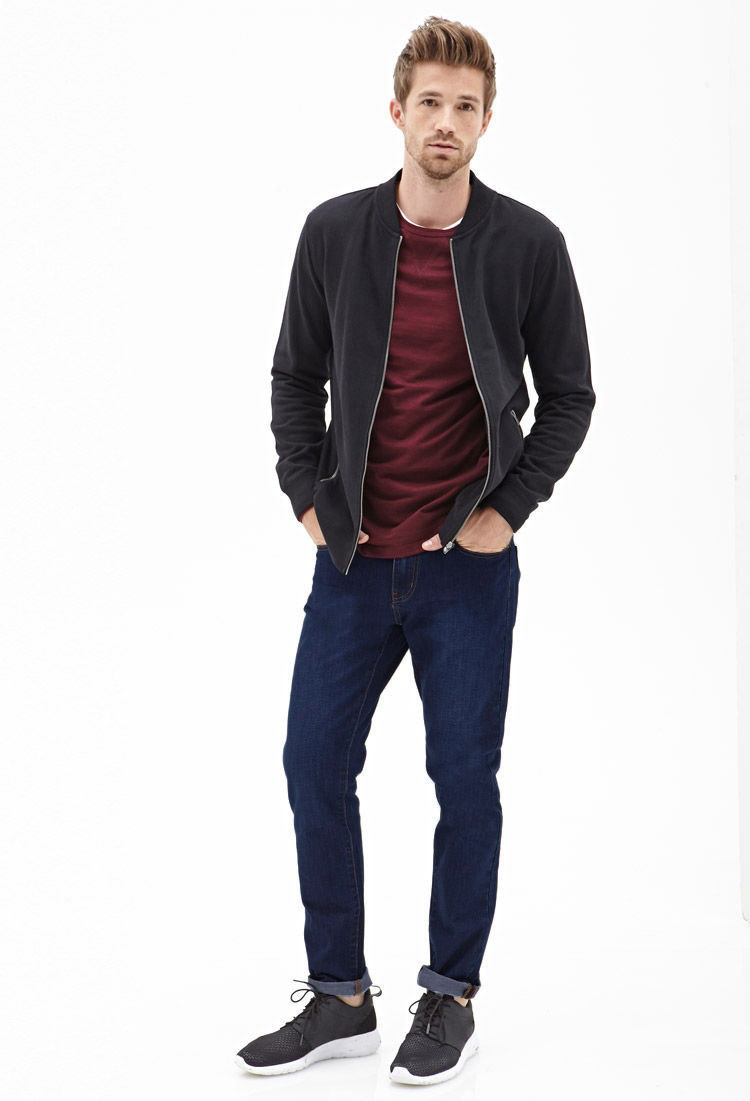

In [11]:
# create an S3 client object
s3 = boto3.client('s3')

# specify the S3 bucket name and file path
bucket_name = 'visualsearch7374'
file_path = 'images/MEN-Denim-id_00000750-01_1_front.jpg'

# read the file from S3
s3_response = s3.get_object(Bucket=bucket_name, Key=file_path)

# get the binary content of the image
image_content = s3_response['Body'].read()

# create an image object from the binary content
image = Image.open(io.BytesIO(image_content))

# show the image
display(image)


In [9]:
from concurrent.futures import ThreadPoolExecutor
# create an S3 client object
s3 = boto3.client('s3')

# specify the S3 bucket name and file paths
bucket_name = 'visualsearch7374'
file_paths = ['images/MEN-Tees_Tanks-id_00006477-01_7_additional.jpg', 'images/MEN-Denim-id_00000750-01_1_front.jpg']

# function to read an image from S3 and return its binary content
def read_image(file_path):
    s3_response = s3.get_object(Bucket=bucket_name, Key=file_path)
    return s3_response['Body'].read()

# use a thread pool to read the images in parallel
with ThreadPoolExecutor() as executor:
    image_contents = list(executor.map(read_image, file_paths))

# create image objects from the binary content 
image_outputs = [Image.open(io.BytesIO(image_content)) for image_content in image_contents]


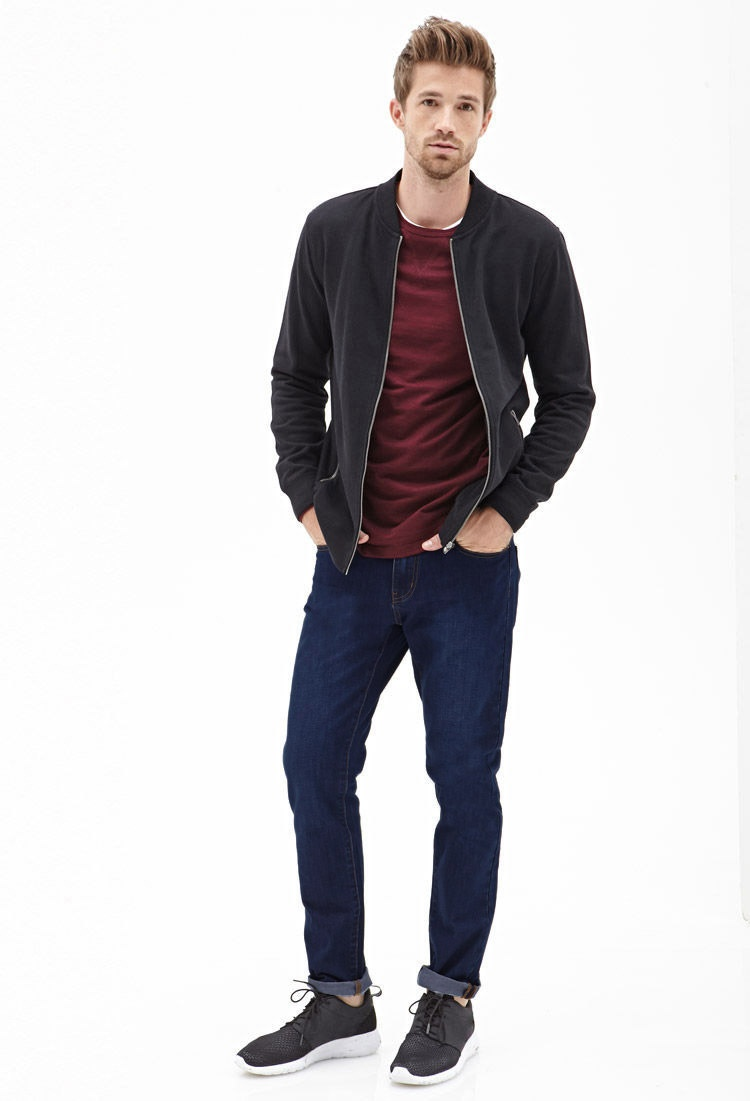

In [11]:
image_outputs[1]